# Import and requirement

In [3]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from itertools import combinations

### Importing the dataset

In [4]:
movie_path = 'data/Movie.pkl'
actor_path = 'data/Actor.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)
    
with open(actor_path, 'rb') as file:
    Actor = pickle.load(file)

# Anaylsis : Relation between actors and directors

Interesting question : \
What is the impact of directors on the network of actors ?
How does the relation between them evolve and change during time ?
Are directors hubs of actors ? 

First of all, a basic description of our data will be done in order to assess and visualize the dataset we have obtained. After that, we will do a sanity check on our database in order to verify that the research questions are indeed feasible and are interesting. Here is the global stategy that will be used in order to assess and analyse the relation between actors and directors :

1) Describe and analyze the data available on actors and directors
2) Create different networks about actors and directors 
3) Extract metrics form (networks statistics) those networks
   
if possible : 

4) Do the same for each year in order to visualize the evolution
5) Analyse the evolution of the metrics from the networks and compare them with other informatrion on the actor carrer evolution

## 1. Creating edges,node

Using the `Movie.pkl` file in order to create different network to print them later. As we are directly using the `Movie.pkl` file, we are only using the film that we successfully managed to merge between the CMU database and the IMDb database. This is intended as we will uing the directors of the movie in this part of the analysis. The directors of each movie were found using the IMDb database, hence only the film successfully merged are relevant. 

In [6]:
def get_films(df):
    # This function transforms the Freebase_movie_ID of a database into a list
    
    list_film = df.Freebase_movie_ID.tolist()
    
    return list_film

In [7]:
def create_Director_to_film_list():
    # This function uses the Movie.pkl dataset in order to create a dataframe 
    # where the first column is the director's director and the second the list of movies he directed 
    
    Movie_bis = Movie.copy()
    # Change the type of the list of index to string in order to separate and split them
    Movie_bis['IMDb_director_ID'] = Movie_bis['IMDb_director_ID'].astype(str).str.split(',')

    # Expand each director_id into its own row in order to have all director separately
    Director_Movie_expanded = Movie_bis.explode('IMDb_director_ID')

    # Group by and get_films in order to have the list of each movie the director directed 
    #Director_film_list = Director_Movie_expanded.groupby(by='IMDb_director_ID').apply(get_films,include_groups=False))
    Director_film_list = pd.DataFrame(Director_Movie_expanded.groupby(by='IMDb_director_ID').apply(get_films,include_groups=False)).reset_index()
    Director_film_list.columns = ['IMDb_director_ID','Freebase_movie_ID']
    
    # Drop the first and second row of the dataframe as they are respectively the \N and Nan index value  
    Director_film_list = Director_film_list.iloc[2:]
    
    return Director_film_list

In [8]:
def create_Film_to_Director_list():
    # This function uses the Movie.pkl dataset in order to create a dataframe 
    # where the first column is the film's unique index and the second the list of the director of the movie
    
    Movie_bis = Movie.copy()
    # Change the type of the list of index to string in order to separate and split them
    Movie_bis['IMDb_director_ID'] = Movie_bis['IMDb_director_ID'].astype(str).str.split(',')
    
    Film_director_list = pd.DataFrame()
    Film_director_list['Freebase_movie_ID'] = Movie_bis['Freebase_movie_ID']
    Film_director_list['IMDb_director_ID'] = Movie_bis['IMDb_director_ID']
    
    Film_director_list = Film_director_list.reset_index(drop=True)
    
    return Film_director_list

In [9]:
def create_Actor_to_film_list():
    # This function uses the Movie.pkl dataset in order to create a dataframe 
    # where the first column is the index's actor and the second the list of movies in which he played
    
    # load the dataset
    character_column = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_release_date','Character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_atmovierelease','freebase_character_actor_map_id','freebase_character_id','Freebase_actor_ID']
    CMU_character = pd.read_csv("data/CMU/character.metadata.tsv", sep='\t',names = character_column, header = 0)

    # Filtering the rows such that only the merged movies are kept
    CMU_character_filtered = CMU_character[CMU_character['Freebase_movie_ID'].isin(Movie['Freebase_movie_ID'])]
    
    # Group by and get_films in order to have the list of each movie the actor played
    Actor_film_list = pd.DataFrame(CMU_character_filtered.groupby(by='Freebase_actor_ID').apply(get_films,include_groups=False)).reset_index()
    Actor_film_list.columns = ['Freebase_actor_ID','Freebase_movie_ID']

    return Actor_film_list

In [10]:
def create_Film_to_actor_list():
    # This function uses the Movie.pkl dataset in order to create a dataframe 
    # where the first column is the index's actor and the second the list of movies in which he played
    
    # load the dataset
    character_column = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_release_date','Character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_atmovierelease','freebase_character_actor_map_id','freebase_character_id','Freebase_actor_ID']
    CMU_character = pd.read_csv("data/CMU/character.metadata.tsv", sep='\t',names = character_column, header = 0)

    # Filtering the rows such that only the merged movies are kept
    CMU_character_filtered = CMU_character[CMU_character['Freebase_movie_ID'].isin(Movie['Freebase_movie_ID'])]
    
    Film_actor_list = CMU_character_filtered.groupby('Freebase_movie_ID').agg({'Freebase_actor_ID': list}).reset_index()

    return Film_actor_list

In [11]:
def create_Director_profile():
    # This function aims to create a profile for each director, containing multiple information

    # Copy of the original dataframe
    Movie_bis = Movie.copy()  
    
    # Need to split the dataframe as there may be multiple directors per movie
    Movie_bis["IMDb_director_ID"] = Movie_bis["IMDb_director_ID"].str.split(",") 
    Movie_bis["director_name"] = Movie_bis["Producer name"].str.split(",")  
    Movie_bis["birthYear_director"] = Movie_bis["birthYear producer"].str.split(",")  
    Movie_bis["deathYear_director"] = Movie_bis["deathYear producer"].str.split(",") 

    # Explode the columns to create one row per director
    Movie_exploded = Movie_bis.explode(["IMDb_director_ID", "director_name", "birthYear_director","deathYear_director"])

    # Creating a column containg the age at the movie release using the birth year and the movie release date
    Movie_exploded["birthYear_director"] = pd.to_numeric(Movie_exploded["birthYear_director"], errors="coerce")
    Movie_exploded["Movie_release_date"] = pd.to_numeric(Movie_exploded["Movie_release_date"], errors="coerce")
    Movie_exploded["age_at_movie_release"] = (
        Movie_exploded["Movie_release_date"] - Movie_exploded["birthYear_director"]
    )

    # Group by director_ID and aggregate relevant data
    Director_profile = (
        Movie_exploded.groupby("IMDb_director_ID")
        .agg({
            "director_name": "first",  
            "birthYear_director": "first",
            "deathYear_director": "first",
            "Freebase_movie_ID": list,  
            "age_at_movie_release": list,  
        })
        .reset_index()  
    )
    return Director_profile

In [37]:
print(Actor.columns)
print(Director_profile.columns)

Index(['Freebase_actor_ID', 'actor_name', 'actor_DOB', 'actor_gender',
       'actor_height', 'actor_ethnicity', 'Freebase_movie_ID',
       'actor_age_atmovierelease'],
      dtype='object')
Index(['IMDb_director_ID', 'director_name', 'birthYear_director',
       'deathYear_director', 'Freebase_movie_ID', 'age_at_movie_release'],
      dtype='object')


In [110]:
def computing_Actor_Director(Director_profile, Actor_profile):
    """
    This function checks whether an actor is also a director. As the ID are not the same, this is done using the name and the birth year.
    Returns two DataFrames:
        - ActorDirector: A DataFrame where the first column is the IMDb_director_ID, the second is the Freebase_actor_ID, 
          and the third is the name of the person.
        - ActorDirectorBirth: A DataFrame with matching individuals including their birthdate if provided in the profiles.
    """
    # Drop the nan so that it does not merge after
    Actor_profile.dropna(axis=0, subset=['actor_DOB','actor_name'], inplace=True)
    Director_profile.dropna(axis=0, subset=['birthYear_director','director_name'], inplace=True)
    
    # Change the format of the date of birth so that both are in year (Actor was YYYY-MM-DD)
    Actor_profile['actor_DOB'] = pd.to_datetime(Actor_profile['actor_DOB'], errors='coerce')
    Actor_profile['actor_DOB'] = Actor_profile['actor_DOB'].dt.year

    Director_profile['birthYear_director'] = pd.to_datetime(Director_profile['birthYear_director'], errors='coerce')
    Director_profile['birthYear_director'] = Director_profile['birthYear_director'].dt.year

    # Creating a new index based on the name of the director and its birthyear
    new_id_dir = Director_profile.birthYear_director.astype(str)+Director_profile.director_name.astype(str)
    Director_profile_newindex = Director_profile.copy()
    Director_profile_newindex.index = new_id_dir
    
    # Creating a new index based on the name of the actor and its birthyear
    new_id_act = Actor_profile.actor_DOB.astype(str)+Actor_profile.actor_name.astype(str)
    Actor_profile_newindex = Actor_profile.copy()
    Actor_profile_newindex.index = new_id_act

    # Checking for duplicate in the director index
    mask_duplicate1 = Director_profile_newindex.index.duplicated(keep=False)
    Director_profile_newindex_wo = Director_profile_newindex[~mask_duplicate1]
    
    # Checking for duplicate in the actor index
    mask_duplicate2 = Actor_profile_newindex.index.duplicated(keep=False)
    Actor_profile_newindex_wo = Actor_profile_newindex[~mask_duplicate2]

    # Finally merging the datasets
    merged = Actor_profile_newindex_wo.merge(Director_profile_newindex_wo, left_index=True, right_index=True, how='inner')
    ActorDirector = merged[['IMDb_director_ID','Freebase_actor_ID','actor_name']].reset_index(drop=True)

    return ActorDirector

In [111]:
ActorDirector = computing_Actor_Director(Director_profile, Actor)
print(ActorDirector.shape)
print(ActorDirector.head())

(2081, 3)
  IMDb_director_ID Freebase_actor_ID          actor_name
0        nm0916131         /m/011lpr           Jack Webb
1        nm0002173         /m/011lvx     Laurie Anderson
2        nm0000126         /m/0127m7       Kevin Costner
3        nm0546672         /m/012bkl  Antonio Margheriti
4        nm2588606         /m/012cj0       Steve McQueen


## 1. Describing/visualizing the data

Plot à faire :

- faire des networks si possible

In [112]:
# Creating the profile of multiple director 
Director_profile = create_Director_profile()

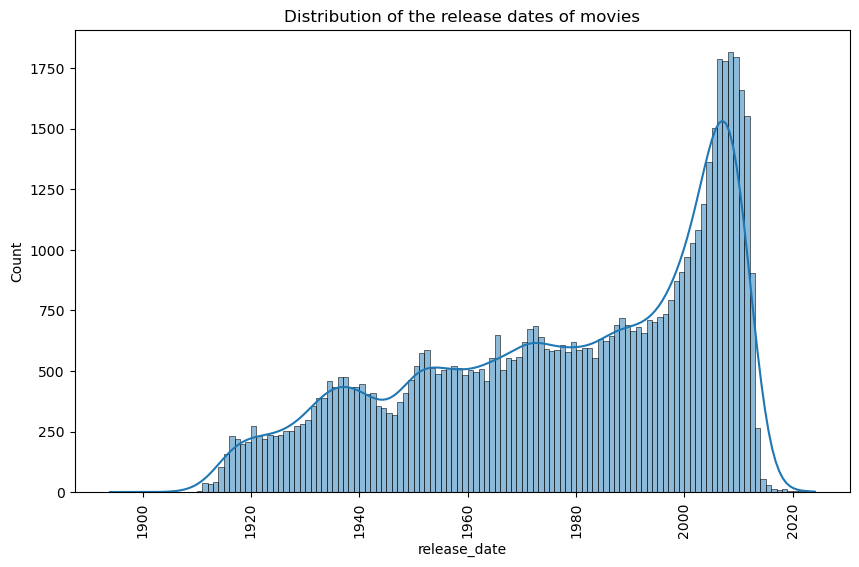

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(Movie, x = "release_date", kde = True, bins = 130)
plt.xticks(rotation=90)
plt.title('Distribution of the release dates of movies',fontsize=14, fontweight="bold")
plt.show()

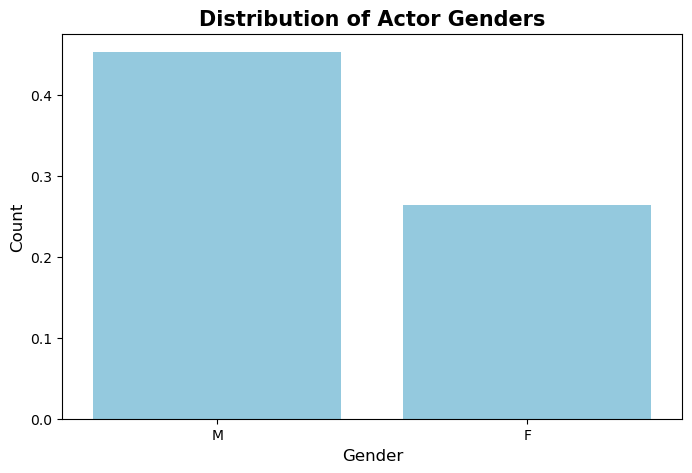

In [30]:
plt.figure(figsize=(8, 5))
sns.countplot(data=Actor, x='actor_gender', stat = 'proportion', color='skyblue')
plt.title('Distribution of Actor Genders',fontsize=15, fontweight = "bold")
plt.xlabel('Gender',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.show()

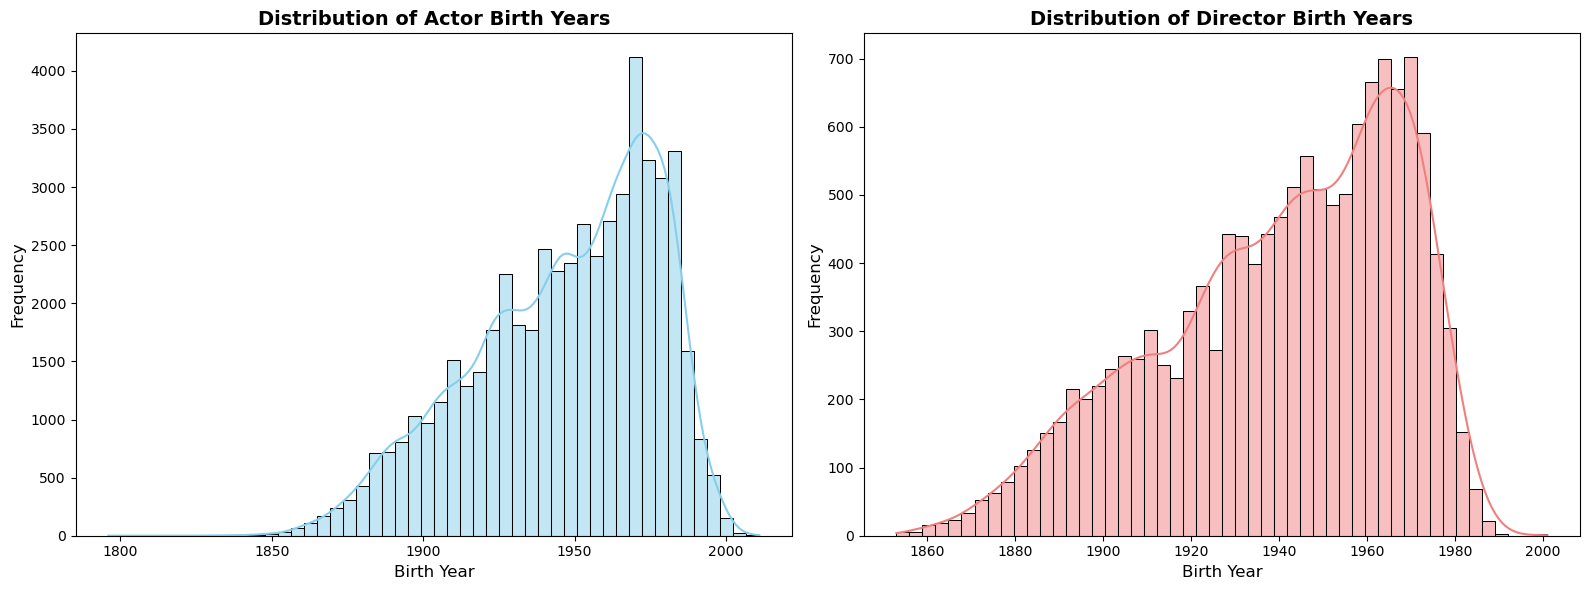

In [31]:
# Set the figure and subplots layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

Actor_bis = Actor.copy()

Actor_bis['actor_DOB'] = pd.to_datetime(Actor_bis['actor_DOB'], errors='coerce')
Actor_bis['Birth_Year'] = Actor_bis['actor_DOB'].dt.year

# Actor DOB
sns.histplot(Actor_bis['Birth_Year'].dropna(), kde=True, bins=50, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Actor Birth Years',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Birth Year',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)


# Director DOB
sns.histplot(Director_profile['birthYear_director'].dropna(), kde=True, bins=50, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution of Director Birth Years',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Birth Year',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)

# Plot
plt.tight_layout()
plt.show()

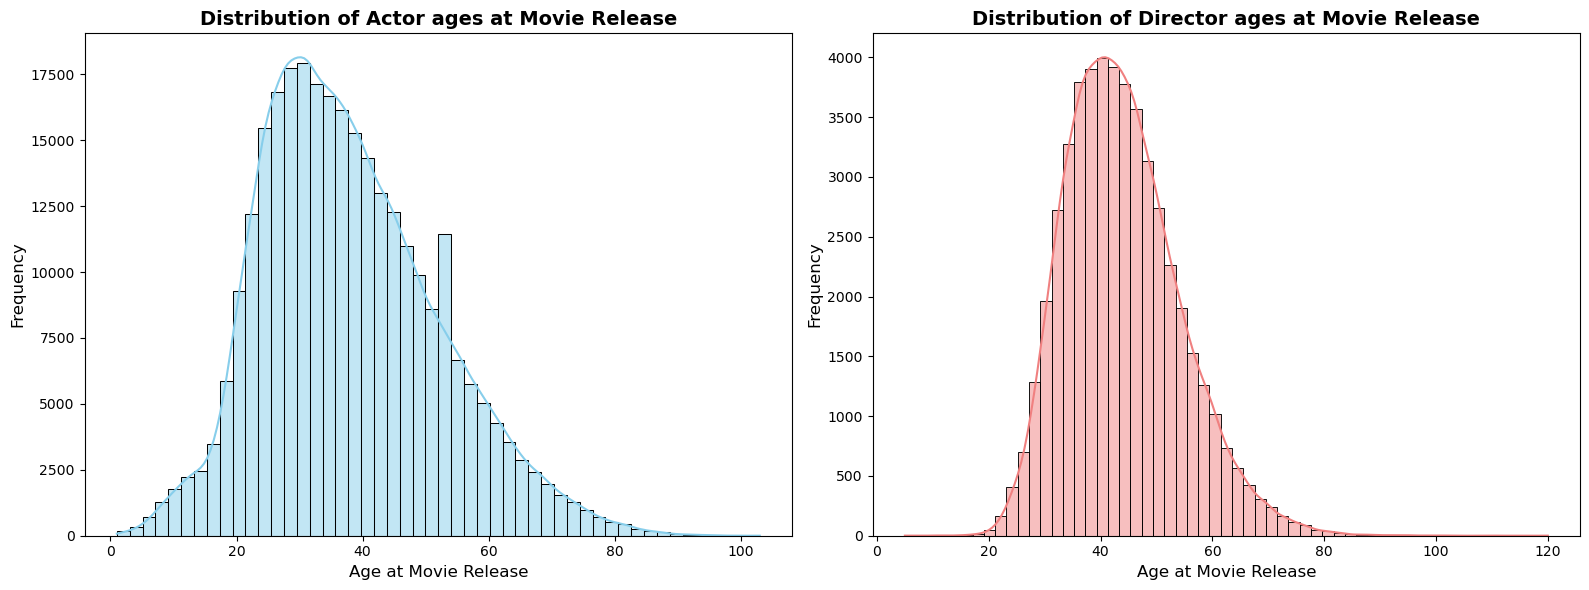

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

Actor_bis = Actor.copy()
Director_bis = Director_profile.copy()

# Need to explose the dataset as the age at movie release is a list
Actors_explo_age = Actor_bis.explode('actor_age_atmovierelease')
Actors_explo_age = Actors_explo_age[Actors_explo_age["actor_age_atmovierelease"]>0]

Directors_explo_age = Director_bis.explode('age_at_movie_release')
Directors_explo_age = Directors_explo_age[Directors_explo_age["age_at_movie_release"]>0]

# Director age at movie release
sns.histplot(Actors_explo_age['actor_age_atmovierelease'].dropna(), kde=True, bins=50, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Actor ages at Movie Release',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Age at Movie Release',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)

# Director age at movie release
sns.histplot(Directors_explo_age['age_at_movie_release'].dropna(), kde=True, bins=57, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution of Director ages at Movie Release',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Age at Movie Release',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)

# Plot
plt.tight_layout()
plt.show()

In [33]:
Actor_bis = Actor.copy()
Director_bis = Director_profile.copy()

# Computing the start of the actor and director carrer 
# Replace NaN with -1 and ensure all values are integers
Actor_bis["actor_age_atmovierelease"] = Actor_bis["actor_age_atmovierelease"].apply(
    lambda x: [-1 if pd.isna(age) or age < 0 else int(age) for age in x]
)
Actor_bis["Career_Start_age"] = Actor_bis.apply(
    lambda row: min((val for val in row["actor_age_atmovierelease"] if val > 0), default=np.NaN),
    axis=1,
)

# Doing the same for the director
Director_bis["age_at_movie_release"] = Director_bis["age_at_movie_release"].apply(
    lambda x: [-1 if pd.isna(age) or age < 0 else int(age) for age in x]
)
Director_bis["Career_Start_age"] = Director_bis.apply(
    lambda row: min((val for val in row["age_at_movie_release"] if val > 0), default=np.NaN),
    axis=1,
)

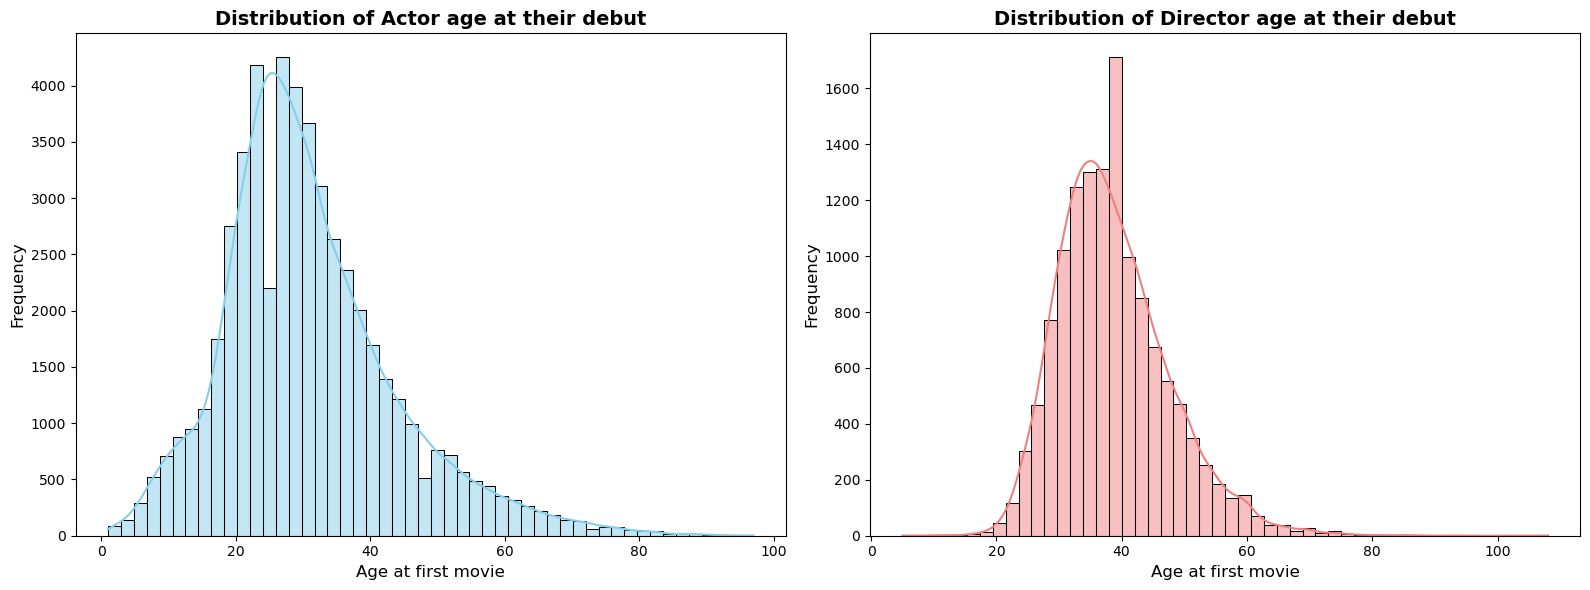

In [34]:
# Plotting the result from the previous cell
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actor age at movie release
sns.histplot(Actor_bis["Career_Start_age"].dropna(), kde=True, bins=50, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Actor age at their debut',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Age at first movie',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)

# Director age at movie release
sns.histplot(Director_bis["Career_Start_age"].dropna(), kde=True, bins=50, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution of Director age at their debut',fontsize=14, fontweight="bold")
axes[1].set_xlabel('Age at first movie',fontsize=12)
axes[1].set_ylabel('Frequency',fontsize=12)

# Plot
plt.tight_layout()
plt.show()

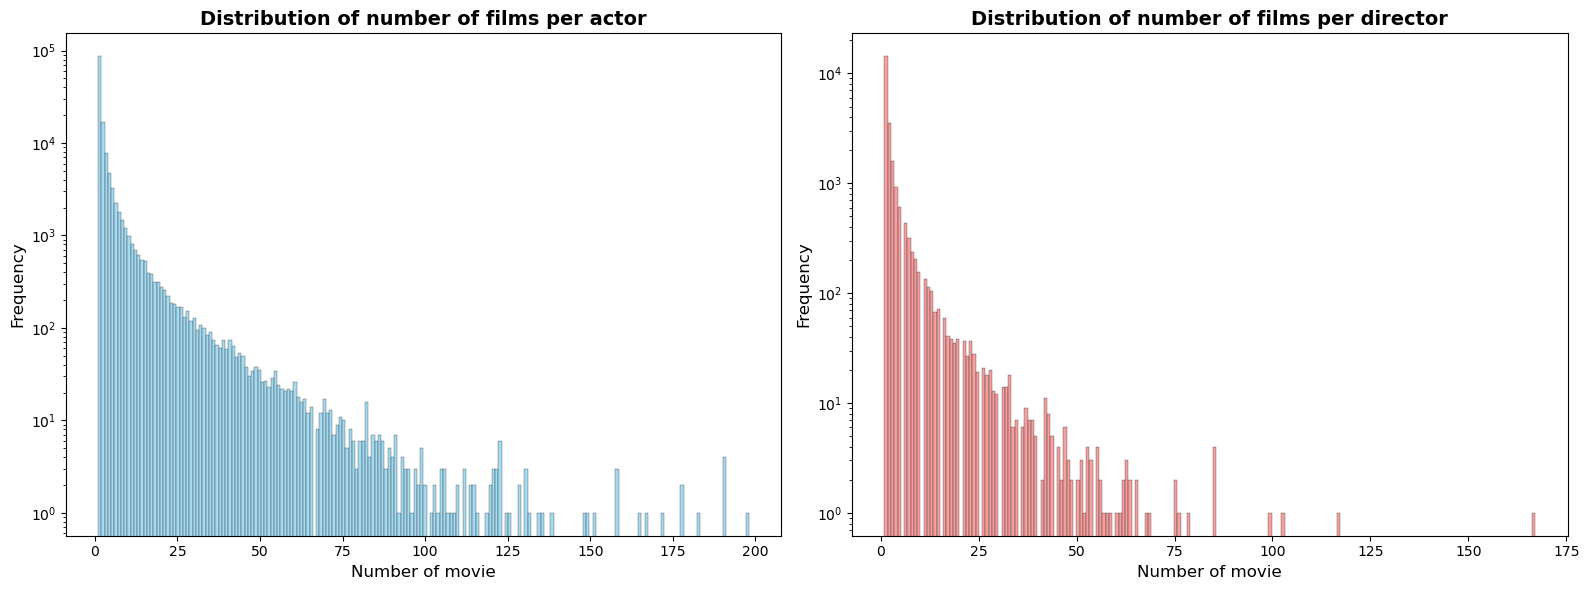

In [35]:
Actor_bis = Actor.copy()
Director_bis = Director_profile.copy()

# Computing the number of films played (directed) by actors (directors)
Actor_bis["Number_of_films"] = Actor_bis["actor_age_atmovierelease"].apply(len)
Director_bis["Number_of_films"] = Director_bis["age_at_movie_release"].apply(len)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actor age at movie release
sns.histplot(Actor_bis[Actor_bis['Number_of_films']<200]['Number_of_films'], bins=200, color='skyblue', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_title('Distribution of number of films per actor',fontsize=14, fontweight="bold")
axes[0].set_xlabel('Number of movie',fontsize=12)
axes[0].set_ylabel('Frequency',fontsize=12)

# Director age at movie release
sns.histplot(Director_bis[Director_bis['Number_of_films']<200]['Number_of_films'], bins=200, color='lightcoral', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Distribution of number of films per director', fontsize=14, fontweight="bold")
axes[1].set_xlabel('Number of movie', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)


# Show the plot
plt.tight_layout()
plt.show()

## 2. Describing the data

## 3. Plotting the networks

Create a network where each node is an Actor ID and create edges between actors how played together

In [13]:
# Using the function in order to create the networks
Director_film_list = create_Director_to_film_list()
Film_director_list = create_Film_to_Director_list()
Actor_film_list = create_Actor_to_film_list()
Film_actor_list = create_Film_to_actor_list()

In [14]:
print(Actor_film_list.head())
print(Actor_film_list.shape)
print("------------------------")
print(Film_actor_list.head())
print(Film_actor_list.shape)

  Freebase_actor_ID                                  Freebase_movie_ID
0          /m/010p3  [/m/08hjr9, /m/06zm9p7, /m/06c5z_, /m/06c5z_, ...
1         /m/010q36                                        [/m/033pf1]
2         /m/010xjr  [/m/0c_6bf, /m/078mm1, /m/03qfyt, /m/0cz7_4w, ...
3         /m/0112yl  [/m/0513nd, /m/05c2g3q, /m/04wjg1, /m/01tch8, ...
4         /m/011_24                            [/m/02stxk, /m/09n9rnb]
(119820, 2)
------------------------
  Freebase_movie_ID                                  Freebase_actor_ID
0         /m/011_mj  [nan, /m/01lc5, /m/03d36rf, /m/0gclz8m, /m/043...
1         /m/011_p6  [/m/02ysx, /m/0ksbyz, /m/05bwd6, /m/03jl2r, /m...
2         /m/011_zy      [/m/039mzr, /m/06bxsw, /m/04jxzf, /m/0266kbw]
3         /m/011wtv  [/m/07r1h, /m/0k525, /m/02k_c1, /m/03w4sh, /m/...
4         /m/011x_4  [/m/0ktdv3, /m/0283dkv, /m/0p_r5, /m/05w1vf, /...
(50753, 2)


In [15]:
print(Director_film_list.head())
print(Director_film_list.shape)
print("------------------------")
print(Film_director_list.head())
print(Film_director_list.shape)

  IMDb_director_ID                                  Freebase_movie_ID
2        nm0000008                                        [/m/02616b]
3        nm0000009                                        [/m/095s_p]
4        nm0000018                           [/m/04f5xbz, /m/0h3ph1j]
5        nm0000019  [/m/09rwr0, /m/0b0gjq, /m/09sgmx, /m/074x3d, /...
6        nm0000032                            [/m/0gwrzx, /m/0406l36]
(23517, 2)
------------------------
  Freebase_movie_ID        IMDb_director_ID
0        /m/02q23xk             [nm0085156]
1        /m/0czdh_n             [nm0714557]
2         /m/0120y4             [nm0846879]
3        /m/03hjcy9             [nm0143333]
4         /m/0fgfyy  [nm0091767, nm0877783]
(61042, 2)


In [24]:
# Create an empty graph
G = nx.Graph()

# Build a dictionary to map each film to the actors who participated in it
movie_to_actors = {}

for _, row in tqdm(Actor_film_list.iterrows()):
    actor_id = row['Freebase_actor_ID']
    films = row['Freebase_movie_ID']
    
    for film in films:
        if film not in movie_to_actors:
            movie_to_actors[film] = []
        movie_to_actors[film].append(actor_id)

# Add edges between actors who share movies
for actors in tqdm(movie_to_actors.values()):
    for actor1, actor2 in combinations(actors, 2):
        G.add_edge(actor1, actor2)

135760it [00:06, 21197.42it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64308/64308 [00:02<00:00, 29284.86it/s]


In [25]:
high_degree_nodes = [node for node, degree in G.degree() if degree > 500]

subgraph = G.subgraph(high_degree_nodes)

print(f"The reduces network contains {subgraph.number_of_nodes()} with a total of {subgraph.number_of_edges()} connections.")

The reduces network contains 380 with a total of 13665 connections.


## 4. Extract metrics from the network

In [62]:
start = time.time()
degrees = dict(played_together.degree())
print(f"Computation time:{time.time()-start:.2f}")

Computation time:0.17


This is too expensive to compute. Maybe try an other library ?

start = time.time()
betweenness_centrality= nx.betweenness_centrality(played_together)
print(f"Computation time:{time.time()-start:.2f}")

In [128]:
start = time.time()
eigenvector_centrality = nx.eigenvector_centrality(played_together) 
print(f"Computation time:{time.time()-start:.2f}")

Computation time:29.53


## 5. Evolution through time ?

dire que étant donné que le merging a pris bcp de temps c'est un peu tight d'aller plus loin maintenant